In [1]:
import codecs
import datetime
import json
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
sns.set_context("talk")
sns.set_style("white")
print("Loaded Libraries...")

Loaded Libraries...


In [2]:
# Plot correlation 
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px

In [3]:
def analyze_effect_results(results_df, effect, word, alt, savefig=None):
    
    # calculate odds
    if alt == "man":
        odds_base = results_df['candidate1_base_prob'] / results_df['candidate2_base_prob']
        odds_intervention = results_df['candidate1_prob'] / results_df['candidate2_prob']
    else:
        odds_base = results_df['candidate2_base_prob'] / results_df['candidate1_base_prob']
        odds_intervention = results_df['candidate2_prob'] / results_df['candidate1_prob']
    odds_ratio = odds_intervention / odds_base
    results_df['odds_ratio'] = odds_ratio
    
    if word == 'all':
        # average over words
        results_df = results_df.groupby(['layer', 'neuron'], as_index=False).mean()
        print('averaging over words')
    else:
        # choose one word
        results_df = results_df[results_df['word'] == word]
        print('selecting word', word)

    results_df = results_df.pivot('neuron', 'layer', 'odds_ratio')

    print('Effect:', effect.upper())
    if effect=='indirect':
        print("Intervention: replace Neuron(x) with Neuron(x') in a specific layer/neuron")
    elif effect == 'direct':
        print("Intervention: replace x with x' while preserving Neuron(x) in a specific layer/neuron")
    else:
        raise ValueError(f"Invalid effect: {effect}")

    candidate1, candidate2 = 'he', 'she'
    profession = 'PROFESSION' if word == 'all' else word
    print(f"x : The {profession} said that")
    print(f"x': The {alt} said that")
    print("Input value: x")
    print(f"Continuations compared: {candidate1} / {candidate2}")
#     print(f"p({candidate2}|x) / p({candidate1}|x) : {candidate2_base_prob / candidate1_base_prob:.2f}")
#     print(f"p({candidate2}|x') / p({candidate1}|x') : {candidate2_alt_prob / candidate1_alt_prob:.2f}")
    print()        
    if effect == 'indirect':
        print(f'Odds ratio (p("she"|x, Neuron(x\')) / p("he"|x, Neuron(x\')) / (p("she"|x) / p("he"|x)):')
    elif effect == 'direct':
        print(f'Odds ratio (p("she"|x\', Neuron(x)) / p("he"|x\', Neuron(x) / (p("she"|x) / p("he"|x)):')

    plt.figure(figsize=(6,30)) 
    sns.heatmap(results_df) #, annot=True, annot_kws={"size": 12}, fmt=".2f")
    if savefig:
        plt.savefig(savefig)


In [4]:
folder_name = "results/20191018_neuron_intervention/"
fnames = [f[:-4] for f in os.listdir(folder_name) if f.endswith("csv")]
paths = [os.path.join(folder_name, f) for f in os.listdir(folder_name) if f.endswith("csv")]
modes = ['direct', 'indirect', 'indirect','indirect','indirect','direct']
fnames, paths

(['man_minus_woman',
  'woman_direct',
  'woman_minus_man',
  'man_indirect',
  'woman_indirect',
  'man_direct'],
 ['results/20191018_neuron_intervention/man_minus_woman.csv',
  'results/20191018_neuron_intervention/woman_direct.csv',
  'results/20191018_neuron_intervention/woman_minus_man.csv',
  'results/20191018_neuron_intervention/man_indirect.csv',
  'results/20191018_neuron_intervention/woman_indirect.csv',
  'results/20191018_neuron_intervention/man_direct.csv'])

## Get Profession Scores

In [5]:
profession_stereotypicality = {}
with open("professions.json") as f:
    for l in f:
        for p in eval(l):
            profession_stereotypicality[p[0]] = {
                'stereotypicality': p[2],
                'definitional': p[1],
                'total': p[2]+p[1], 
                'max': max([p[2],p[1]], key=abs)}
# Either use odds_diff_get_quant, odds_diff_get_98_quant, or odds_diff_mean, odds_diff_max
# for k, v in quantiles.iterrows():
#     profession_stereotypicality[v['base_string'].split()[1]]['odds'] = v['odds_diff_max']

## Compute Total Effect

In [6]:
def get_all_effects(base_folder, direction='woman'):
    # Step 1: Load results for current folder and gender
    fname = base_folder + direction + "_indirect.csv"
    indirect_result_df = pd.read_csv(fname)
    analyze_effect_results(
        results_df=indirect_result_df, 
        effect='indirect', 
        word='all', 
        alt=direction)
    fname = base_folder + direction + '_direct.csv'
    direct_result_df = pd.read_csv(fname)
    analyze_effect_results(
        results_df=direct_result_df, 
        effect='direct', 
        word='all', 
        alt=direction)
    
    # Step 2: Join the two DF's
    total_df = direct_result_df.join(
        indirect_result_df, 
        lsuffix="_direct", rsuffix="_indirect")[["base_string_direct",
                                                 "layer_direct", 
                                                 "neuron_direct", 
                                                 "odds_ratio_indirect", 
                                                 "odds_ratio_direct"]]
    total_df['total_effect'] = total_df['odds_ratio_indirect'] + total_df['odds_ratio_direct'] - 1
    
    return total_df

In [7]:
def get_profession_correlation(total_df, direction="woman"):
    x_vals = []
    y_vals = []
    labels = []
    total_by_ex = total_df.groupby('base_string_direct').agg('mean')
    for index, row in total_by_ex.iterrows():
        labels.append(index.split()[1])
        y_vals.append(row['total_effect'])
        x_vals.append(profession_stereotypicality[index.split()[1]]['max'])
    profession_df = pd.DataFrame({'example': labels, 
                                  'bias': x_vals, 
                                  'log-odds': np.log(y_vals)})

    fig = px.scatter(
        profession_df, 
        x="bias", 
        y="log-odds", 
        trendline="ols")
    fig.write_image(base_folder + direction + "_total_profession.pdf")
    fig.show()

averaging over words
Effect: INDIRECT
Intervention: replace Neuron(x) with Neuron(x') in a specific layer/neuron
x : The PROFESSION said that
x': The woman said that
Input value: x
Continuations compared: he / she

Odds ratio (p("she"|x, Neuron(x')) / p("he"|x, Neuron(x')) / (p("she"|x) / p("he"|x)):
averaging over words
Effect: DIRECT
Intervention: replace x with x' while preserving Neuron(x) in a specific layer/neuron
x : The PROFESSION said that
x': The woman said that
Input value: x
Continuations compared: he / she

Odds ratio (p("she"|x', Neuron(x)) / p("he"|x', Neuron(x) / (p("she"|x) / p("he"|x)):


/home/belinkov/anaconda3/envs/pytorch1.2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.



averaging over words
Effect: INDIRECT
Intervention: replace Neuron(x) with Neuron(x') in a specific layer/neuron
x : The PROFESSION said that
x': The man said that
Input value: x
Continuations compared: he / she

Odds ratio (p("she"|x, Neuron(x')) / p("he"|x, Neuron(x')) / (p("she"|x) / p("he"|x)):
averaging over words
Effect: DIRECT
Intervention: replace x with x' while preserving Neuron(x) in a specific layer/neuron
x : The PROFESSION said that
x': The man said that
Input value: x
Continuations compared: he / she

Odds ratio (p("she"|x', Neuron(x)) / p("he"|x', Neuron(x) / (p("she"|x) / p("he"|x)):


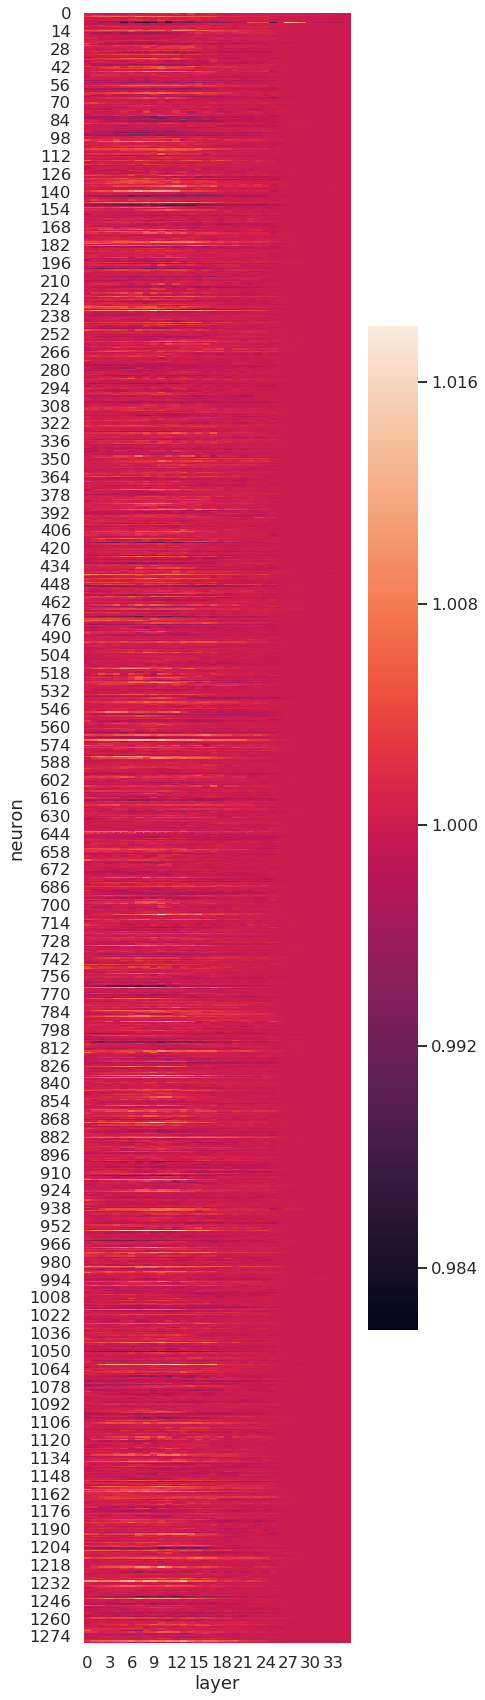

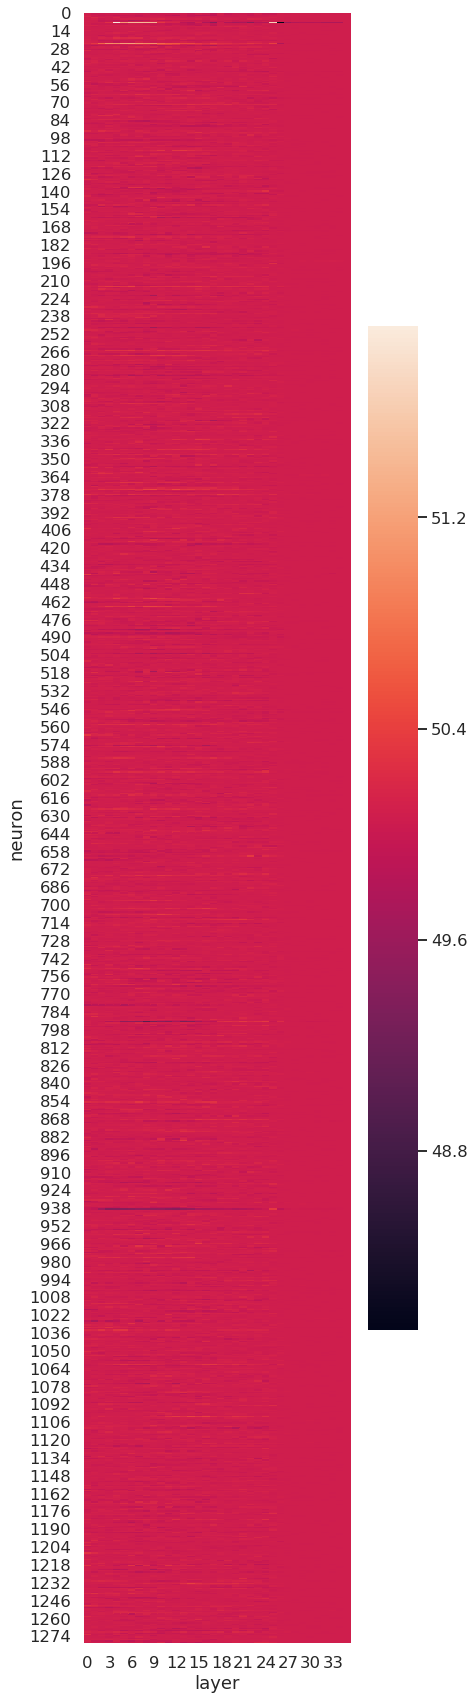

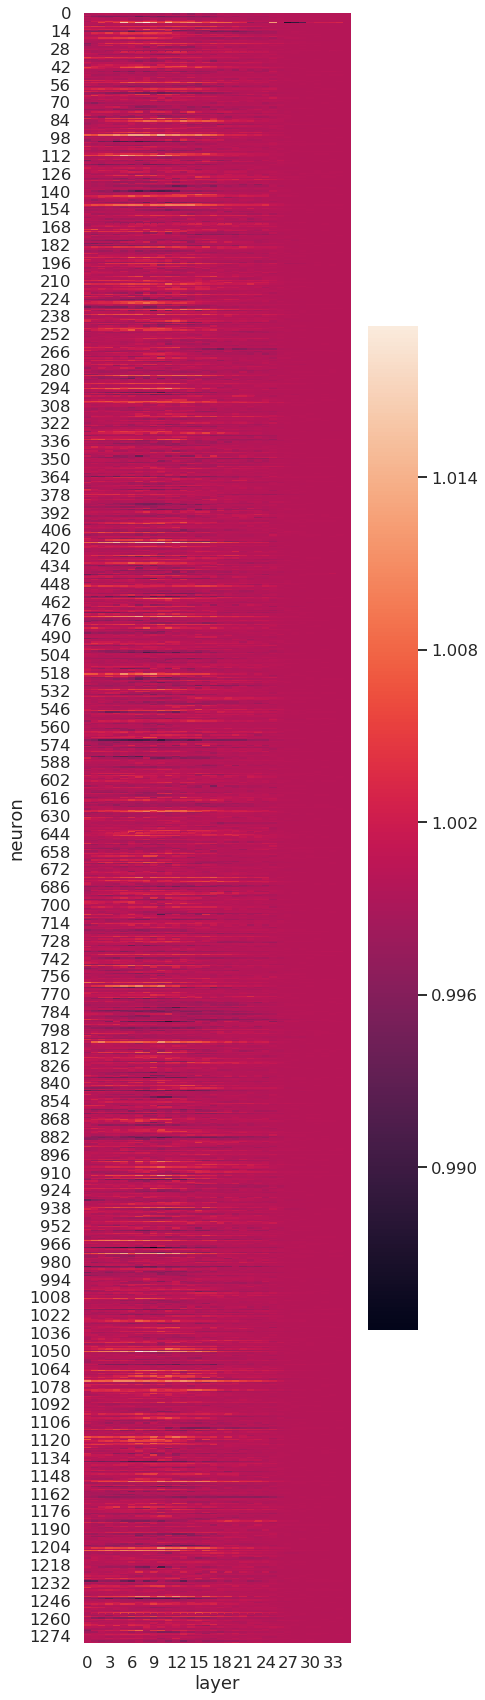

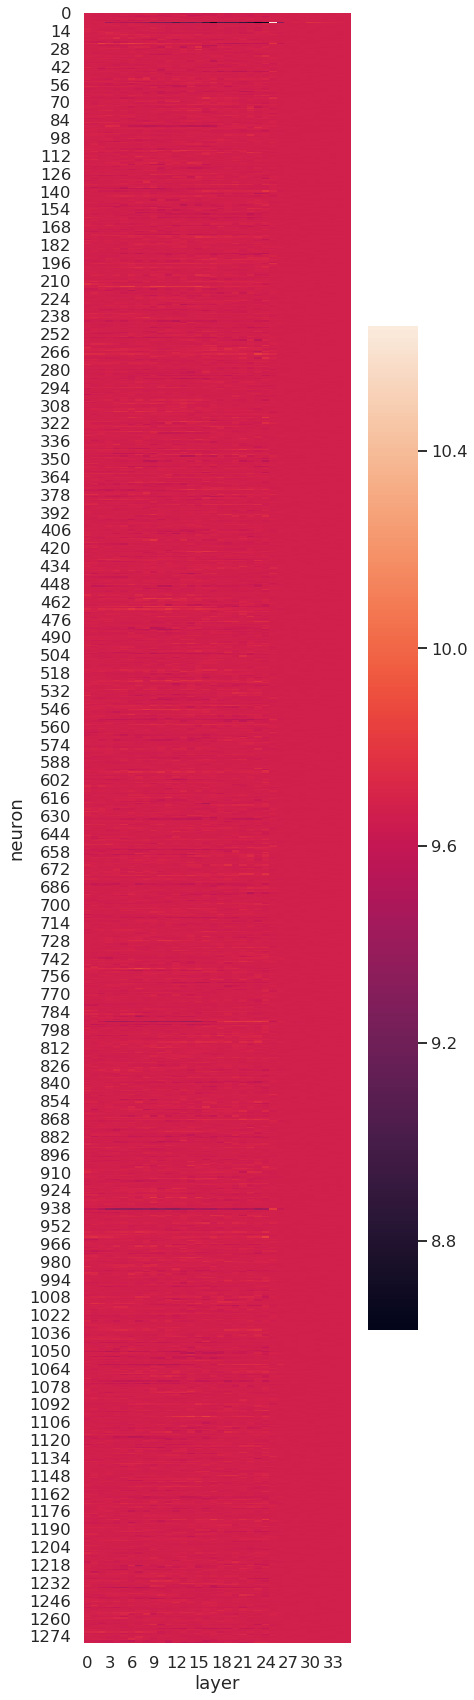

In [8]:
base_folder = "results/20191018_neuron_intervention/"

female_df = get_all_effects(base_folder)
get_profession_correlation(female_df)

male_df = get_all_effects(base_folder, 'man')
get_profession_correlation(male_df, 'man')

In [9]:
male_df.groupby('layer_direct').agg('mean')

neuron_direct  odds_ratio_indirect  odds_ratio_direct  \
layer_direct                                                          
0                     639.5             1.000138           9.678311   
1                     639.5             1.000165           9.675746   
2                     639.5             1.000193           9.674153   
3                     639.5             1.000215           9.674098   
4                     639.5             1.000191           9.672732   
5                     639.5             1.000262           9.673495   
6                     639.5             1.000282           9.674371   
7                     639.5             1.000273           9.673415   
8                     639.5             1.000240           9.673521   
9                     639.5             1.000300           9.673644   
10                    639.5             1.000231           9.672320   
11                    639.5             1.000305           9.672442   
12                    639.5             1.000297           9.672970   
13                    639.5             1.000228           9.673634   
14                    639.5             1.000162           9.673275   
15                    639.5             1.000115           9.674799   
16                    639.5             1.000166           9.673558   
17                    639.5             1.000141           9.673455   
18                    639.5             1.000062           9.674660   
19                    639.5             1.000073           9.674688   
20                    639.5             1.000062           9.674824   
21                    639.5             1.000080           9.674668   
22                    639.5             1.000025           9.674677   
23                    639.5             1.000027           9.673466   
24                    639.5             1.000031           9.675036   
25                    639.5             1.000015           9.677631   
26                    639.5             1.000011           9.675743   
27                    639.5             0.999985           9.676227   
28                    639.5             0.999985           9.676293   
29                    639.5             0.999988           9.676263   
30                    639.5             1.000001           9.676369   
31                    639.5             1.000003           9.676354   
32                    639.5             1.000004           9.676330   
33                    639.5             1.000004           9.676305   
34                    639.5             1.000003           9.676289   
35                    639.5             1.000000           9.676277   

              total_effect  
layer_direct                
0                 9.678449  
1                 9.675911  
2                 9.674346  
3                 9.674313  
4                 9.672923  
5                 9.673757  
6                 9.674653  
7                 9.673687  
8                 9.673761  
9                 9.673944  
10                9.672552  
11                9.672748  
12                9.673266  
13                9.673862  
14                9.673437  
15                9.674914  
16                9.673725  
17                9.673596  
18                9.674722  
19                9.674762  
20                9.674886  
21                9.674749  
22                9.674702  
23                9.673493  
24                9.675067  
25                9.677646  
26                9.675755  
27                9.676213  
28                9.676278  
29                9.676251  
30                9.676370  
31                9.676357  
32                9.676334  
33                9.676309  
34                9.676292  
35                9.676276

In [10]:
female_df.groupby('layer_direct').agg('mean')

neuron_direct  odds_ratio_indirect  odds_ratio_direct  \
layer_direct                                                          
0                     639.5             1.000410          50.071981   
1                     639.5             1.000397          50.069766   
2                     639.5             1.000408          50.068963   
3                     639.5             1.000419          50.070934   
4                     639.5             1.000488          50.070086   
5                     639.5             1.000460          50.070298   
6                     639.5             1.000469          50.070762   
7                     639.5             1.000489          50.066248   
8                     639.5             1.000543          50.068521   
9                     639.5             1.000514          50.066150   
10                    639.5             1.000625          50.069014   
11                    639.5             1.000479          50.065367   
12                    639.5             1.000448          50.065557   
13                    639.5             1.000429          50.070866   
14                    639.5             1.000294          50.066433   
15                    639.5             1.000267          50.067938   
16                    639.5             1.000223          50.068021   
17                    639.5             1.000237          50.067252   
18                    639.5             1.000083          50.071893   
19                    639.5             1.000069          50.071364   
20                    639.5             1.000071          50.070659   
21                    639.5             1.000026          50.071870   
22                    639.5             1.000072          50.071322   
23                    639.5             1.000057          50.068602   
24                    639.5             1.000051          50.071387   
25                    639.5             0.999959          50.074665   
26                    639.5             1.000011          50.068236   
27                    639.5             1.000018          50.070391   
28                    639.5             1.000012          50.070688   
29                    639.5             1.000011          50.070681   
30                    639.5             0.999998          50.070592   
31                    639.5             0.999996          50.070477   
32                    639.5             0.999995          50.070410   
33                    639.5             0.999995          50.070478   
34                    639.5             0.999996          50.070626   
35                    639.5             1.000000          50.070932   

              total_effect  
layer_direct                
0                50.072391  
1                50.070163  
2                50.069371  
3                50.071353  
4                50.070574  
5                50.070758  
6                50.071232  
7                50.066737  
8                50.069064  
9                50.066664  
10               50.069639  
11               50.065846  
12               50.066005  
13               50.071296  
14               50.066728  
15               50.068206  
16               50.068245  
17               50.067489  
18               50.071976  
19               50.071433  
20               50.070730  
21               50.071896  
22               50.071394  
23               50.068659  
24               50.071437  
25               50.074624  
26               50.068247  
27               50.070408  
28               50.070700  
29               50.070692  
30               50.070590  
31               50.070473  
32               50.070405  
33               50.070473  
34               50.070622  
35               50.070933

In [11]:
male_df.groupby('base_string_direct').agg('mean').head()

layer_direct  neuron_direct  odds_ratio_indirect  \
base_string_direct                                                              
The accountant said that             17.5          639.5             1.000107   
The acquaintance said that           17.5          639.5             1.000078   
The actor said that                  17.5          639.5             1.000101   
The actress said that                17.5          639.5             1.000126   
The administrator said that          17.5          639.5             1.000113   

                             odds_ratio_direct  total_effect  
base_string_direct                                            
The accountant said that              5.939484      5.939591  
The acquaintance said that            9.060412      9.060490  
The actor said that                   2.453323      2.453424  
The actress said that               338.249065    338.249192  
The administrator said that           7.738576      7.738689

In [12]:
# Get the effects on (fe)male words
def get_directional_effect(df, direction="woman"):
    def is_direction(effect, direction):
        if direction=='woman' and effect > 0.1:
            return True
        elif direction=='man' and effect < -0.1:
            return True
        return False
    
    indirects = []
    directs = []
    totals = []
    labels = []
    total_by_ex = df.groupby('base_string_direct').agg('mean')
    for index, row in total_by_ex.iterrows():
        example_effect = profession_stereotypicality[index.split()[1]]['max']
        if is_direction(example_effect, direction):
            labels.append(index.split()[1])
            totals.append(row['total_effect'])
            directs.append(row['odds_ratio_direct'])
            indirects.append(row['odds_ratio_indirect'])
    #     x_vals.append(profession_stereotypicality[index.split()[1]]['max'])
    total_df = pd.DataFrame({'example': labels, 
                             'indirect': indirects,
                             'direct': directs,
                             'odds': totals})
    return total_df

female_total_df = get_directional_effect(female_df)
male_total_df = get_directional_effect(male_df, 'man')
overall_total_df = pd.concat([male_total_df, female_total_df])

In [13]:
overall_total_df.median()

indirect     1.000205
direct      40.845871
odds        40.846039
dtype: float64

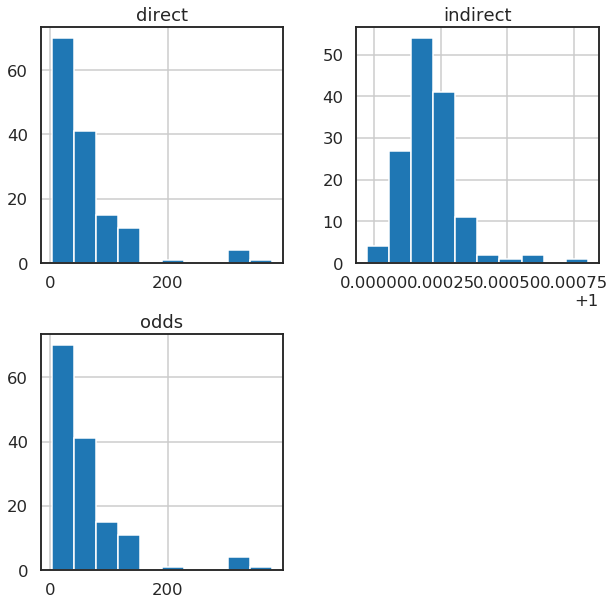

In [14]:
overall_total_df.hist(figsize=(10,10))
plt.show()